In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gzip 
# Input data files are available in the "../input/" directory.
# For preprocessing
from sklearn import preprocessing

import os
# print(os.listdir('../'))
# print(os.listdir("../input"))
print("pandas: {}".format(pd.__version__))
print('numpy: {}'.format(np.__version__))
# Any results you write to the current directory are saved as output.

pandas: 0.23.3
numpy: 1.15.4


In [5]:
FOLDER = '/home/pablo/Data/Predict-Future-Sales/'  # at home
# FOLDER = '/home/pibieta/Data/Future-Sales/'  # at ifusp
print(os.listdir(FOLDER))

['sample_submission.csv.gz', 'test.csv.gz', 'item_categories.csv', 'shops.csv', 'items.csv', 'sales_train.csv.gz']


In [6]:
# %%time
shops_df = pd.read_csv(FOLDER + '/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})  
                            # col'umns: ['shop_name','shop_id']
item_cat_df = pd.read_csv(FOLDER+'/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'}) 
items_df = pd.read_csv(FOLDER + '/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})  
                            # ['item_name','item_id','item_category_id']                            # columns: ['item_category_name', 'item_category_id']
sales_train_df  = pd.read_csv(FOLDER + '/sales_train.csv.gz', compression = 'gzip', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}) 
                            # ['date','date_block_num','shop_id','item_id','item_price', 'item_cnt_day']

    
sample_sub_df = pd.read_csv(FOLDER+'/sample_submission.csv.gz', compression = 'gzip')  # ['ID',item_cnt_month']
test_df = pd.read_csv(FOLDER+'/test.csv.gz', compression = 'gzip',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}) # [shop_id','item_id']

In [6]:
# test_df = pd.read_csv(FOLDER+'/test.csv.gz', compression = 'gzip',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}) # [shop_id','item_id']

In [7]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Pipeline:
1. Eliminate Outliers from the train set.
2. Perform Feature Engineering.
3. Merge with the test_df to include **missing values**.
4. Construct the final train dataset, this is, properly fill **missing values**.
5. Play with models.


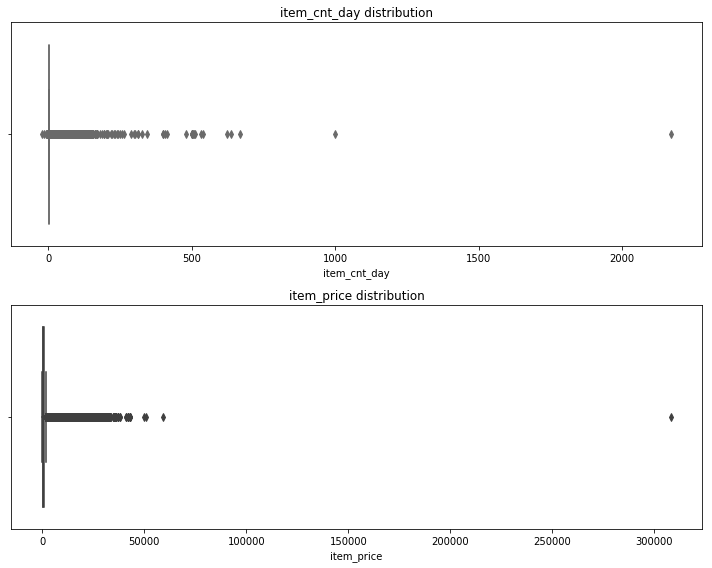

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,4))
# plt.xlim(-100, 3000)
sns.boxplot(x=sales_train_df['item_cnt_day'], ax =ax[0], palette='Set3' ).set_title('item_cnt_day distribution')
# plt.figure(figsize=(10,4))
# plt.xlim(sales_train_df['item_price'].min(), sales_train_df['item_price'].max())
sns.boxplot(x=sales_train_df['item_price'], ax = ax[1] ).set_title('item_price distribution')
plt.tight_layout()
plt.show()

In [9]:
# There are repeated shops with different id let's correct this
# Якутск Орджоникидзе, 56
sales_train_df.loc[sales_train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train_df.loc[sales_train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train_df.loc[sales_train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

In [10]:
# Remove outliers
train_0 = sales_train_df.query('item_cnt_day > 0 and item_cnt_day <= 400 and item_price <= 40000')

In [11]:
sales_by_shop = sales_train_df.pivot_table(index = ['shop_id'], values = ['item_cnt_day'], columns = ['date_block_num'], 
                                           aggfunc=np.sum, fill_value = 0).reset_index()
sales_by_shop.columns = sales_by_shop.columns.droplevel().map(str)
sales_by_shop = sales_by_shop.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop.columns.values[0] = 'shop_id'

The following figure gives an idea of sales behavior during the two years we have data

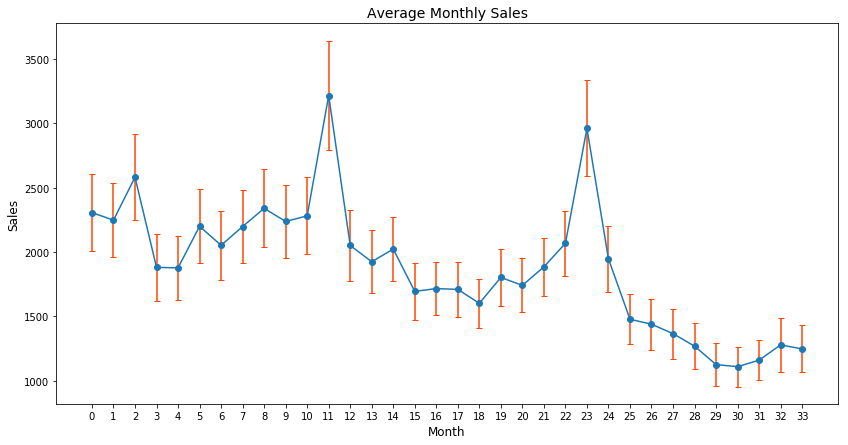

In [12]:
plt.figure(figsize=(14,7))
plt.errorbar(sales_by_shop.columns[1:], sales_by_shop.iloc[:,1:].mean(), 
             yerr=sales_by_shop.iloc[:,1:].std()/sales_by_shop.iloc[:,1:].count().add(-1).pow(0.5), fmt='-o', ecolor='orangered',capsize=3)
plt.title('Average Monthly Sales', fontsize=14)
plt.xlabel('Month', fontsize= 12 )
plt.ylabel('Sales', fontsize = 12)
plt.show()

# Category_id:

The general ide is to perform data augmentation and to get statistics aggregating by these augmented features.

Let us begin with `item_category_id` variable, we first note -by looking at `item_cat_df`- that we can split the category information into two subcategories, these can be used to refine our statistics, as we shall see.

We will label encode these new features and then include them in the `sales_train_df` dataset

In [13]:

#----------> Write this cell as a function!!!!!!!!!!!!!!!!!!


new = item_cat_df['item_category_name'].str.split(' - ', expand =True)
new[1]=new[1].fillna('none')
#Label encoding these two new columns
le1 = preprocessing.LabelEncoder()
le1.fit(new[0].unique())
new[2] = le1.transform(new[0])
le2 = preprocessing.LabelEncoder()
le2.fit(new[1].unique())
new[3] = le2.transform(new[1])

# Create a copy and fill it with the new columns
item_cat_exp = item_cat_df.copy() 
item_cat_exp['cat_type'] = new[0]
item_cat_exp['item_type'] = new[1]
item_cat_exp['cat_type_l'] = new[2]
item_cat_exp['item_type_l'] = new[3]
item_cat_exp.drop('item_category_name', axis =1, inplace= True)
item_cat_exp.head()

,item_category_id,cat_type,item_type,cat_type_l,item_type_l
0,0,PC,Гарнитуры/Наушники,0,31
1,1,Аксессуары,PS2,1,11
2,2,Аксессуары,PS3,1,12
3,3,Аксессуары,PS4,1,13
4,4,Аксессуары,PSP,1,15


In [14]:
item_cat_exp.shape

(84, 5)

## Train and Test datasets

In [15]:
train = sales_train_df.join(items_df, on='item_id', rsuffix='_')\
    .join(shops_df, on='shop_id', rsuffix='_')\
    .join(item_cat_df, on='item_category_id', rsuffix='_')\
    .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
# train.head()
test = test_df.join(items_df, on='item_id', rsuffix='_')\
    .join(shops_df, on='shop_id', rsuffix='_')\
    .join(item_cat_df, on='item_category_id', rsuffix='_')\
    .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)


In [16]:
test.head().T

,0,1,2,3,4
ID,0,1,2,3,4
shop_id,5,5,5,5,5
item_id,5037,5320,5233,5232,5268
item_name,"NHL 15 [PS3, русские субтитры]",ONE DIRECTION Made In The A.M.,"Need for Speed Rivals (Essentials) [PS3, русск...","Need for Speed Rivals (Classics) [Xbox 360, ру...","Need for Speed [PS4, русская версия]"
item_category_id,19,55,19,23,20
shop_name,"Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад"""
item_category_name,Игры - PS3,Музыка - CD локального производства,Игры - PS3,Игры - XBOX 360,Игры - PS4


In [17]:
# Time period 
print('train shape: {}'.format(train.shape))
print('time period:\n\t start -> {} \n\t  end -> {} '.format(train['date'].min().date(), train['date'].max().date()))

train shape: (2935849, 10)
time period:
	 start -> 2013-01-01 
	  end -> 2015-12-10 


In [18]:
# Perform the cut
train = train.query('item_price > 0 and item_price < 40000')
train = train.query('item_cnt_day <= 20')
train = train.drop(['item_name', 'shop_name', 'item_category_name'], axis = 1)
test = test.drop(['item_name', 'shop_name', 'item_category_name'], axis = 1)
train.head().T
# train.shape

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_category_id,37,58,58,58,56


In [19]:
train = train.join(item_cat_exp, on = 'item_category_id', rsuffix = "_").drop(['item_category_id_', 'cat_type', 'item_type'], axis =1)
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_category_id,37,58,58,58,56
cat_type_l,11,13,13,13,13
item_type_l,1,29,29,29,5


In [20]:
# The function below groups the dataframe by the set of columns in groups and aggregates the keys of dic_agg
#  by the methods specified as the values of dic_agg

def monthly_agg(df, groups, dic_agg = {'item_price': ['mean','std', 'max', 'min'], 
                                       'item_cnt_day': ['sum','count','mean', 'std']}, 
                sort_column = 'date', fill0 = False, rename_col = False):
#     add the month column
    groups = ['date_block_num'] + groups
#     define auxiliar variable for column name changing
    col_names = groups + [(str(key)+'_'+str(value)) for key in dic_agg.keys() for value in dic_agg[key]]
#  back to business
    g_df = df.sort_values(sort_column).groupby(groups, as_index = False)
    agg_df = g_df.agg(dic_agg)
    if fill0 == True:
        agg_df.fillna(0, inplace= True)
    if rename_col == True:
        agg_df.columns = col_names
    return agg_df



# The Idea:
 To forget about predicting using the `item_id`, since we do not have enough statistics for such index. We will rather go up one level and consider aggregated features, such that they have meaningful statistics.
 For instance, `item_category_id`, `cat_type_l` and `item_type_l`, let's see:

In [21]:
# First we sort by date and group by month and shop
groups = ['shop_id']
dic_agg={'item_cnt_day': ['sum','count']}
train_shop = monthly_agg(train, groups, dic_agg, rename_col = True)
train_shop.columns = ['date_block_num', 'shop_id', 'item_cnt_shop', 'events_cnt_shop']
train_shop.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,2,3,4,6,7
item_cnt_shop,1146,767,2114,3686,2495
events_cnt_shop,1071,749,1894,3254,2278


In [22]:
# By item_category_id
groups = ['item_category_id']
dic_agg = {'item_cnt_day': ['sum', 'count']}
train_category_id = monthly_agg(train, groups, dic_agg, rename_col= True)
train_category_id.columns = ['date_block_num', 'item_category_id', 'cat_id_item_cnt',
       'cat_id_events_cnt'] 
train_category_id.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
item_category_id,0,1,2,3,4
cat_id_item_cnt,1,1,1390,440,251
cat_id_events_cnt,1,1,1263,334,238


In [23]:
# By cat_type
groups = ['cat_type_l']
dic_agg = {'item_cnt_day': ['sum', 'count']}
train_cat_type = monthly_agg(train, groups, dic_agg, rename_col= True)
train_cat_type.columns = ['date_block_num', 'cat_type_l', 'cat_type_item_cnt',
       'cat_type_events_cnt'] 
train_cat_type.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
cat_type_l,0,1,3,4,5
cat_type_item_cnt,1,3575,149,870,18555
cat_type_events_cnt,1,3216,43,836,16870


In [24]:
#  By item_type
groups = ['item_type_l']
dic_agg = {'item_cnt_day': ['sum', 'count']}
train_it_type = monthly_agg(train, groups, dic_agg, rename_col= True)
train_it_type.columns = ['date_block_num', 'item_type_l', 'item_type_item_cnt',
       'item_type_events_cnt'] 
train_it_type.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
item_type_l,0,1,2,4,5
item_type_item_cnt,677,6094,1630,12527,268
item_type_events_cnt,601,5785,1599,12211,266


All the above aggrupations seem to consist of several items, we may extract good statistics from them, notice they are obtained by grouping monthly, so we are obtaining monthly stats.

For each `feat` in `['item_category_id','cat_type_l','item_type']` we will perform the following:
 * For a pair `(shop_id,feat)` the probability of shop = `shop_id` selling items from feat = `feat` is given by:
   $$p_{\text{shop}}^{\text{feat}}= \dfrac{n_{\text{shop}}^{\text{feat}}}{n_{\text{all}}^{\text{feat}}},$$
   where $n_{\text{shop}}^{\text{feat}}$ is the number of elements of `feat` sold in `shop_id` and $n_{\text{all}}^{\text{feat}}$ is the total number of sales for the whole period of time (months 0-33) of that particular `feat`.
 * Given that probability, one can predict the number of items of a particular `feat` sold in `shop_id`, by:
 $$ n_{34, \text{shop}}^{\text{feat}}= n_{34}^{feat}  p_{\text{shop}}^{\text{feat}},$$
   the task of the predictive model will be to find $n_{34}^{feat}$  using some model, for instance, linear regression.
 * For each shop, one can find the number of items of `feat` that are sold by month, this is the number of required products, then:
 $$n_{\text{shop,item}} = \dfrac{ n_{34, \text{shop}}^{\text{feat}}}{\text{req. products}},$$
   this is the final prediction, for each feat. you can submit the average and check the score.

In [25]:
def get_monthly_probabilities(df, base, group, sort_by = ['date'], agg_dic={'item_cnt_day' : 'sum'}):
# Group the train dataset by each feature in group and feats, we are calculating totals
    groups = base + group
#     group monthly and aggregate, those are the totals
    month = df.sort_values(sort_by).groupby(base, as_index = False).agg(agg_dic)
    month_group = df.sort_values(sort_by).groupby(groups, as_index = False).agg(agg_dic)
    month_group=pd.merge(month_group, month, on= base, how= 'left', suffixes=('','_totals'))
    month_group['prob_'+str(group)] = month_group['item_cnt_day'] / month_group['item_cnt_day_totals']
#     month_group = month_group.rename(columns = {'item_cnt_day_totals': str(group)+'_totals'})
    month_group = month_group.drop(['item_cnt_day','item_cnt_day_totals'], axis=1)
    return month_group

In [26]:
month_shop = get_monthly_probabilities(train,base = ['date_block_num'],group=['shop_id'])
month_cat_id = get_monthly_probabilities(train, base = ['date_block_num','shop_id'],group = ['item_category_id'])
month_cat_type = get_monthly_probabilities(train, base = ['date_block_num','shop_id'],group = ['cat_type_l'])
month_item_type = get_monthly_probabilities(train, base = ['date_block_num','shop_id'],group = ['item_type_l'])

In [27]:
train_0 = pd.merge(train, month_shop, on =['date_block_num','shop_id'], how='left')
train_0 = pd.merge(train_0, month_cat_id, on =['date_block_num','shop_id','item_category_id'], how='left')
train_0 = pd.merge(train_0, month_cat_type, on =['date_block_num','shop_id','cat_type_l'], how='left')
train_0 = pd.merge(train_0, month_item_type, on =['date_block_num','shop_id','item_type_l'], how='left')

train_0.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_category_id,37,58,58,58,56
cat_type_l,11,13,13,13,13
item_type_l,1,29,29,29,5
prob_['shop_id'],0.0153736,0.0626148,0.0626148,0.0626148,0.0626148


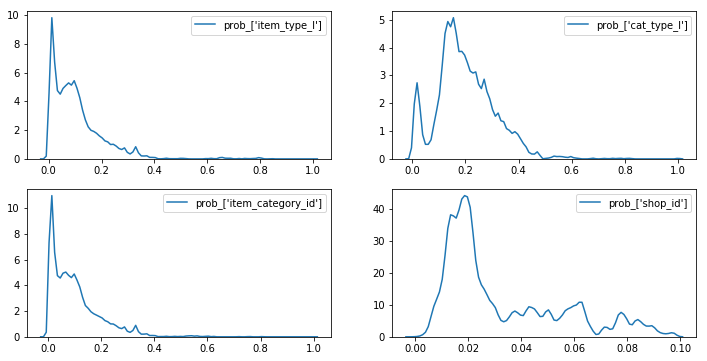

In [25]:
fig, ax= plt.subplots(2,2, figsize = (12,6))
sns.kdeplot(train_0['prob_[\'item_type_l\']'], ax=ax[0][0])
sns.kdeplot(train_0['prob_[\'cat_type_l\']'], ax= ax[0][1])
sns.kdeplot(train_0['prob_[\'item_category_id\']'],ax = ax[1][0])
sns.kdeplot(train_0['prob_[\'shop_id\']'], ax=ax[1][1])


We got the monthly probabilities for all features in `feats`, this is:
$$p_{\text{shop}}^{\text{feat}}= \dfrac{n_{\text{shop}}^{\text{feat}}}{n_{\text{all}}^{\text{feat}}},$$

Now, we need to estimate $n_{34}^{\text{feat}}$ in order to obtain:
$$ n_{34, \text{shop}}^{\text{feat}}= n_{34}^{feat}  p_{\text{shop}}^{\text{feat}},$$

In [28]:
cat_id_month_totals = train_0.sort_values('date').groupby(['date_block_num','item_category_id']).agg({'item_cnt_day': 'sum'}).reset_index()
cat_type_month_totals = train_0.sort_values('date').groupby(['date_block_num','cat_type_l']).agg({'item_cnt_day': 'sum'}).reset_index()
item_type_month_totals = train_0.sort_values('date').groupby(['date_block_num','item_type_l']).agg({'item_cnt_day': 'sum'}).reset_index()
item_type_month_totals.head()

,date_block_num,item_type_l,item_cnt_day
0,0,0,677
1,0,1,6094
2,0,2,1630
3,0,4,12527
4,0,5,268


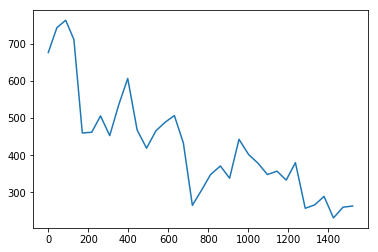

In [31]:
# These are the time series we are supposed to predict
item_type_month_totals[item_type_month_totals['item_type_l'] == 0]['item_cnt_day'].plot()

# Naive Approach:
Let us use the previous month value as the actual prediction, this is,  
$$n_{34}^{\text{feat}}= n_{33}^{\text{feat}}, $$
let us start with `category_id`

In [145]:
# Augment the test_set
test = test.join(item_cat_exp, on = 'item_category_id', rsuffix = "_").drop(['item_category_id_', 'cat_type', 'item_type'], axis =1)

In [114]:
cat_id_month_totals = cat_id_month_totals.rename(columns = {'item_cnt_day': 'cat_id_tot'})
cat_type_month_totals = cat_type_month_totals.rename(columns = {'item_cnt_day': 'cat_type_tot'})
item_type_month_totals = item_type_month_totals.rename(columns = {'item_cnt_day': 'it_type_tot'})

In [115]:
#take last month for each category
last_month_cat = cat_id_month_totals[cat_id_month_totals['date_block_num']== 33]
last_month_cat_type = cat_type_month_totals[cat_type_month_totals['date_block_num']== 33]
last_month_it_type = item_type_month_totals[item_type_month_totals['date_block_num']== 33]
last_month_it_type.head()

,date_block_num,item_type_l,it_type_tot
1521,33,0,263
1522,33,1,3896
1523,33,2,983
1524,33,4,5808
1525,33,5,179


In [162]:
# month_cat_id[month_cat_id['date_block_num']==33]
# month_cat_id[(month_cat_id['shop_id']==2) & (month_cat_id['item_category_id']==19)]['prob_[\'item_category_id\']'].plot()
last_month_prob_cat_id = month_cat_id[month_cat_id['date_block_num']==33]
last_month_prob_cat_type = month_cat_type[month_cat_type['date_block_num']==33]
last_month_prob_item_type = month_item_type[month_item_type['date_block_num']==33]

last_month_prob_item_type.head()

,date_block_num,shop_id,item_type_l,prob_['item_type_l']
50458,33,2,0,0.005502
50459,33,2,1,0.067400
50460,33,2,2,0.009629
50461,33,2,4,0.002751
50462,33,2,5,0.001376


In [188]:
test_cat =0
# category_id
test_cat = test.merge(last_month_cat, on =['item_category_id'], how='left')\
.merge(last_month_prob_cat_id, on=['shop_id','item_category_id'], how='left', suffixes = ['','_'])

test_cat = test_cat.drop(['date_block_num', 'date_block_num_','cat_type_l_','item_type_l_'], axis =1)
test_cat['cat_shop_tot'] = test_cat['cat_id_tot'] * test_cat['prob_[\'item_category_id\']']

# category type
test_cat = test_cat.merge(last_month_cat_type, on =['cat_type_l'], how='left')\
.merge(last_month_prob_cat_type, on=['shop_id','cat_type_l'], how='left', suffixes = ['','_'])

test_cat = test_cat.drop(['date_block_num', 'date_block_num_'], axis =1)
test_cat['cat_type_shop_tot'] = test_cat['cat_type_tot'] * test_cat['prob_[\'cat_type_l\']']

#item_type
test_cat = test_cat.merge(last_month_it_type, on =['item_type_l'], how='left', suffixes=('','_'))\
 .merge(last_month_prob_item_type, on=['shop_id','item_type_l'], how='left', suffixes = ['','_'])

test_cat = test_cat.drop(['date_block_num', 'date_block_num_'], axis =1)
test_cat['it_type_shop_tot'] = test_cat['it_type_tot'] * test_cat['prob_[\'item_type_l\']']


test_cat.head().T

,0,1,2,3,4
ID,0.000000,1.000000,2.000000,3.000000,4.000000
shop_id,5.000000,5.000000,5.000000,5.000000,5.000000
item_id,5037.000000,5320.000000,5233.000000,5232.000000,5268.000000
item_category_id,19.000000,55.000000,19.000000,23.000000,20.000000
cat_type_l,5.000000,13.000000,5.000000,5.000000,5.000000
item_type_l,12.000000,4.000000,12.000000,18.000000,13.000000
cat_id_tot,2443.000000,5808.000000,2443.000000,2203.000000,6260.000000
prob_['item_category_id'],0.071293,0.100760,0.071293,0.052281,0.085551
cat_shop_tot,174.168251,585.216730,174.168251,115.175856,535.551331
cat_type_tot,12772.000000,6814.000000,12772.000000,12772.000000,12772.000000


The `cat_shop_tot` column stores $n_{34}^{\text{cat}}$, now we need to estimate this by item, we can simply divide by the total number of items in the category in question that were sold in the store at month 33, for instance.

In [189]:
shop_cat_id_totals = train_0[train_0['date_block_num'] == 33].sort_values('date').groupby(['shop_id','item_category_id']).agg({'item_cnt_day': 'sum'}).reset_index()
shop_cat_id_totals.columns = ['shop_id', 'item_category_id', 'shop_cat_tot']

shop_cat_type_totals = train_0[train_0['date_block_num'] == 33].sort_values('date').groupby(['shop_id','cat_type_l']).agg({'item_cnt_day': 'sum'}).reset_index()
shop_cat_type_totals.columns = ['shop_id', 'cat_type_l', 'shop_cat_type_tot']

shop_item_type_totals = train_0[train_0['date_block_num'] == 33].sort_values('date').groupby(['shop_id','item_type_l']).agg({'item_cnt_day': 'sum'}).reset_index()
shop_item_type_totals.columns = ['shop_id', 'item_type_l', 'shop_it_type_tot']


shop_item_type_totals.head()

,shop_id,item_type_l,shop_it_type_tot
0,2,0,4
1,2,1,49
2,2,2,7
3,2,4,2
4,2,5,1


In [190]:
test_cat = test_cat.merge(shop_cat_id_totals, on = ['shop_id', 'item_category_id'], how ='left')
test_cat = test_cat.merge(shop_cat_type_totals, on = ['shop_id', 'cat_type_l'], how ='left')
test_cat = test_cat.merge(shop_item_type_totals, on = ['shop_id', 'item_type_l'], how ='left')

test_cat['item_cnt_pred_cat'] = test_cat['cat_shop_tot']/test_cat['shop_cat_tot']
test_cat['item_cnt_pred_cat_type'] = test_cat['cat_type_shop_tot']/test_cat['shop_cat_type_tot']
test_cat['item_cnt_pred_item_type'] = test_cat['it_type_shop_tot']/test_cat['shop_it_type_tot']

test_cat.head().T

,0,1,2,3,4
ID,0.000000,1.000000,2.000000,3.000000,4.000000
shop_id,5.000000,5.000000,5.000000,5.000000,5.000000
item_id,5037.000000,5320.000000,5233.000000,5232.000000,5268.000000
item_category_id,19.000000,55.000000,19.000000,23.000000,20.000000
cat_type_l,5.000000,13.000000,5.000000,5.000000,5.000000
item_type_l,12.000000,4.000000,12.000000,18.000000,13.000000
cat_id_tot,2443.000000,5808.000000,2443.000000,2203.000000,6260.000000
prob_['item_category_id'],0.071293,0.100760,0.071293,0.052281,0.085551
cat_shop_tot,174.168251,585.216730,174.168251,115.175856,535.551331
cat_type_tot,12772.000000,6814.000000,12772.000000,12772.000000,12772.000000


In [111]:
# submission_df= test_cat[['ID', 'item_cnt_pred']]
submission_df= test_cat[['ID', 'item_cnt_pred_item_type']]
submission_df.columns=['ID','item_cnt_month']
submission_df['item_cnt_month'].fillna(0, inplace=True)
submission_df['item_cnt_month'] = submission_df['item_cnt_month'].clip(0,20)
submission_df.to_csv('submission1.csv', index=False)
submission_df.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ID,item_cnt_month
0,0,2.322243
1,1,5.520913
2,2,2.322243
3,3,2.094106
4,4,5.950570


## Cat_type: